In [5]:
import os 
import zipfile 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping,ModelCheckpoint

In [6]:
train_path="data/classification/train"
test_path="data/classification/test"
val_path="data/classification/valid"

In [7]:
IDG = ImageDataGenerator()
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_generator = test_datagen.flow_from_directory(test_path,target_size=(224,224), class_mode = 'binary',batch_size = 32)
train_generator = train_datagen.flow_from_directory(train_path, batch_size = 8, class_mode = 'binary', target_size = (224, 224))
val_generator = test_datagen.flow_from_directory( val_path,  batch_size = 8, class_mode = 'binary', target_size = (224, 224))

Found 20 images belonging to 2 classes.
Found 160 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [8]:
from tensorflow.keras.applications.vgg16 import VGG16
pre_trained_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
for layer in pre_trained_model.layers:
    layer.trainable = False
print(pre_trained_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
from tensorflow.keras.layers import *
last_output = pre_trained_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dense(2, activation = 'softmax')(vgg_x)
model = Model(pre_trained_model.input, vgg_x)
#model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])


#x = layers.Flatten()(pre_trained_model.output)
#x = tf.keras.layers.Dense(256, activation='relu')(x)
#x = tf.keras.layers.Dense(128, activation='relu')(x)
#x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
#model = tf.keras.Model(pre_trained_model.input, x)

In [10]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import numpy as np
mc = ModelCheckpoint('model/VGG16_model12.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)


model.compile(optimizer = 'adam',loss='binary_crossentropy',metrics=['acc'])

In [11]:

vgghist = model.fit(train_generator, validation_data = val_generator, steps_per_epoch = 100, epochs = 50, callbacks=[mc])
#,lr_reducer])

Epoch 1/50
 20/100 [=====>........................] - ETA: 3:55 - loss: nan - acc: 0.5250WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 5000 batches). You may need to use the repeat() function when building your dataset.

Epoch 00001: val_loss did not improve from inf
 20/100 [=====>........................] - 68s 3s/step - loss: nan - acc: 0.5250 - val_loss: nan - val_acc: 0.5000


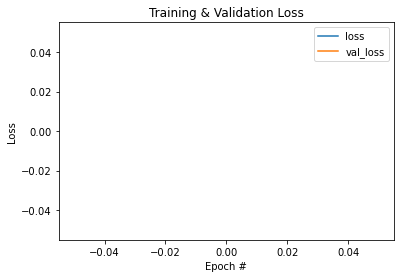

In [8]:
import matplotlib.pyplot as plt
# plot training history
plt.figure()
plt.plot(vgghist.history['loss'], label='loss')
plt.plot(vgghist.history['val_loss'], label='val_loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.savefig("plot/VGG16_model2_L.svg")
plt.show()

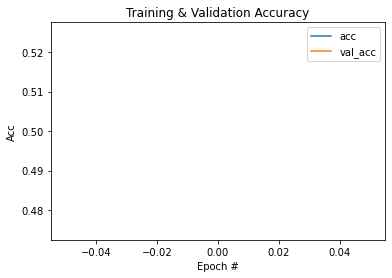

In [9]:
import matplotlib.pyplot as plt
# plot training history
plt.figure()
plt.plot(vgghist.history['acc'], label='acc')
plt.plot(vgghist.history['val_acc'], label='val_acc')
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()
plt.savefig("plot/VGG16_model2_A.svg")
plt.show()

In [10]:
test_generator = test_datagen.flow_from_directory(test_path,target_size=(224,224), class_mode = 'categorical')
from tensorflow import keras
from tensorflow.keras.models import load_model
model2 = load_model("model/VGG16_model2.hdf5")
model2.evaluate_generator(test_generator)

Found 20 images belonging to 2 classes.


OSError: SavedModel file does not exist at: model/VGG16_model2.hdf5/{saved_model.pbtxt|saved_model.pb}